In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pygam import LogisticGAM, s
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from pygam import LogisticGAM, s ,te
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss



df = pd.read_excel('5-Pumpkin_Seeds_Dataset.xlsx')


X = df[['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length','Convex_Area']].to_numpy()
y = df['Class'].to_numpy()

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

terms = s(0, n_splines=10)
for i in range(1, 5):
    terms = terms + s(i, n_splines=10)
terms_inter = terms + te(2, 3, n_splines=10)
best_lam = [0.96, 0.01, 120, 0.18, 300.0,1,1] 

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_auc_inter = -1
aucs = []
for tr, va in skf.split(X_train, y_train):
    model_inter_weight= LogisticGAM(terms_inter, lam=best_lam).fit(X_train[tr], y_train[tr])
    prediction_inter_weight = model_inter_weight.predict_proba(X[va])   # probabilities
    aucs.append(roc_auc_score(y[va], prediction_inter_weight))
m = np.mean(aucs)

best_auc_inter_weight,best_model_inter_weight = m  , model_inter_weight

In [3]:
print("Best AUC with interaction terms:", best_auc_inter_weight)

Best AUC with interaction terms: 0.9580312778297744


In [6]:
best_model_inter_weight.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     16.3805
Link Function:                        LogitLink Log Likelihood:                                  -507.4589
Number of Samples:                         1800 AIC:                                             1047.6788
                                                AICc:                                            1048.0375
                                                UBRE:                                               2.5893
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.5928
Feature Function                  Lam

C:\Users\PC\AppData\Local\Temp\ipykernel_3852\1652285986.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  best_model_inter_weight.summary()


CV AUC: 0.9470 ± 0.0200 | CV logloss: 0.2891
Test AUC=0.9491 | logloss=0.2798
最佳阈值: 0.4364
TPR=0.8792 | FPR=0.0885 | Youden’s J=0.7907


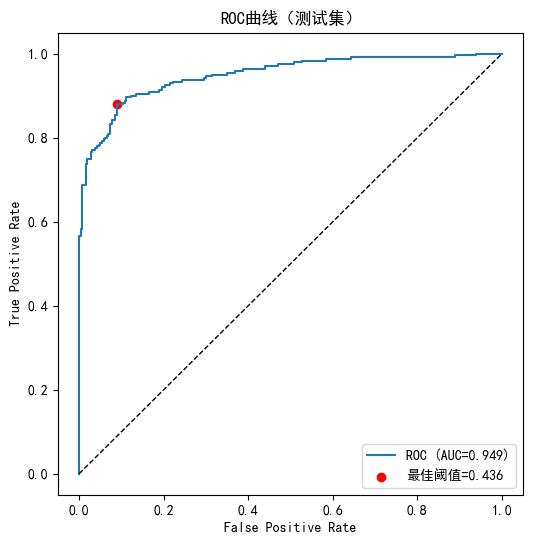

在最优阈值下的准确率: 0.8960


<Figure size 500x500 with 0 Axes>

D:\voice_extraction\voice_emotion_recognition\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 199 (\N{LATIN CAPITAL LETTER C WITH CEDILLA}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)
D:\voice_extraction\voice_emotion_recognition\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 231 (\N{LATIN SMALL LETTER C WITH CEDILLA}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)
D:\voice_extraction\voice_emotion_recognition\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 220 (\N{LATIN CAPITAL LETTER U WITH DIAERESIS}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


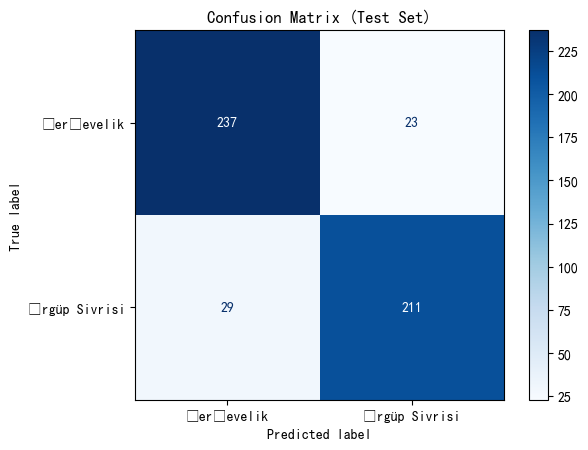

混淆矩阵：
[[237  23]
 [ 29 211]]


In [1]:
# ===== 依赖 =====
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, log_loss, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)

from pygam import LogisticGAM, s, te

# ===== 读数与准备 =====
df = pd.read_excel('5-Pumpkin_Seeds_Dataset.xlsx')

feature_names = ['Area', 'Major_Axis_Length', 'Minor_Axis_Length', 'Convex_Area']
X_raw = df[feature_names].to_numpy()
y_raw = df['Class'].to_numpy()

le = LabelEncoder()
y = le.fit_transform(y_raw)

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 构造 GAM =====
terms = s(0, n_splines=10)
for i in range(1, 4):
    terms = terms + s(i, n_splines=10)
terms_inter = terms + te(2, 3, n_splines=10)

best_lam = [0.96, 120.0, 0.18, 300.0, [1.0, 1.0]]

# ===== 10折交叉验证 =====
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_aucs, cv_lls = [], []

for tr, va in skf.split(X_train, y_train):
    model_cv = LogisticGAM(terms_inter, lam=best_lam, max_iter=1000).fit(X_train[tr], y_train[tr])
    prob_cv  = model_cv.predict_mu(X_train[va])
    cv_aucs.append(roc_auc_score(y_train[va], prob_cv))
    cv_lls.append(log_loss(y_train[va], prob_cv, labels=[0, 1]))

print(f"CV AUC: {np.mean(cv_aucs):.4f} ± {np.std(cv_aucs):.4f} | CV logloss: {np.mean(cv_lls):.4f}")

# ===== 全训练集拟合 =====
best_model_inter_weight = LogisticGAM(terms_inter, lam=best_lam, max_iter=1000).fit(X_train, y_train)

# ===== 测试集预测 =====
prob_test = best_model_inter_weight.predict_mu(X_test)
auc_test  = roc_auc_score(y_test, prob_test)
ll_test   = log_loss(y_test, prob_test, labels=[0, 1])
print(f"Test AUC={auc_test:.4f} | logloss={ll_test:.4f}")

# ===== ROC曲线 & 最优阈值 =====
fpr, tpr, thresholds = roc_curve(y_test, prob_test)
youden_J = tpr - fpr
best_idx = np.argmax(youden_J)
best_thresh = thresholds[best_idx]

print(f"最佳阈值: {best_thresh:.4f}")
print(f"TPR={tpr[best_idx]:.4f} | FPR={fpr[best_idx]:.4f} | Youden’s J={youden_J[best_idx]:.4f}")

# ===== ROC 曲线绘制 =====
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体支持中文
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_test:.3f})')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'最佳阈值={best_thresh:.3f}')
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC曲线（测试集）')
plt.legend()
plt.show()

# ===== 混淆矩阵 =====
y_pred_best = (prob_test >= best_thresh).astype(int)
acc_best = accuracy_score(y_test, y_pred_best)
print(f"在最优阈值下的准确率: {acc_best:.4f}")

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

print("混淆矩阵：")
print(cm)


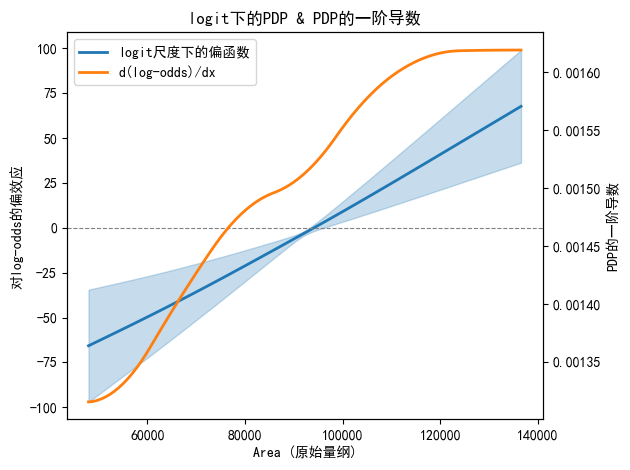

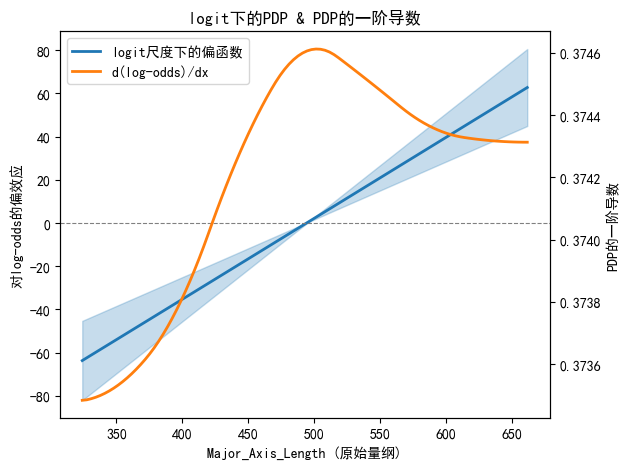

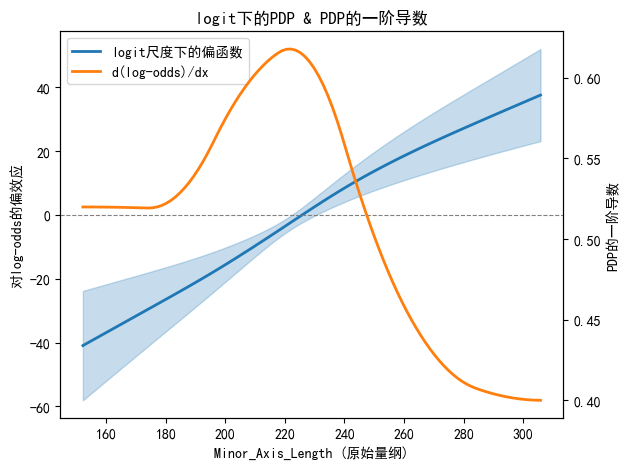

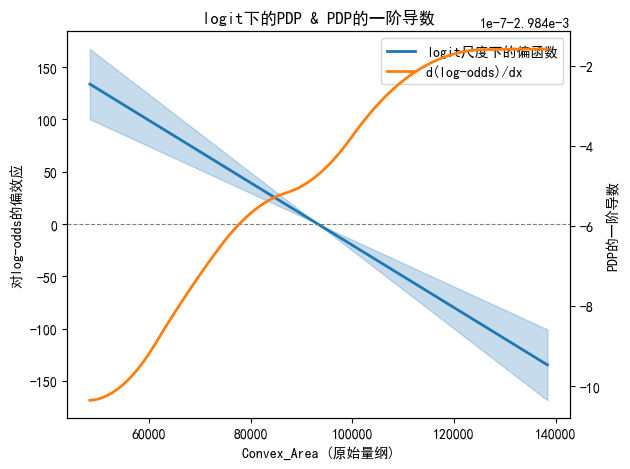

In [45]:
from matplotlib import pyplot as plt
import numpy as np

def finite_diff(x, y):
    x = np.asarray(x); y = np.asarray(y)
    return np.gradient(y, x)

# 取当前 matplotlib 配色的前两种颜色，保证两条曲线颜色不同
_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
c_pdp, c_der = _palette[0], _palette[1]

for i, term in enumerate(best_model_inter_weight.terms):
    # 跳过截距与 2D 张量项，只处理一维 s() 项
    if getattr(term, 'isintercept', False):
        continue
    feat = getattr(term, 'feature', None)
    if feat is None:
        continue
    # term.feature 可能是标量或长度为1的序列
    if isinstance(feat, (list, tuple, np.ndarray)):
        if np.size(feat) != 1:
            continue  # te(...) 等 2D 项跳过
        feat_idx = int(np.array(feat).ravel()[0])
    else:
        feat_idx = int(feat)

    # 生成网格（标准化尺度）并取 link 尺度的偏依赖与其 95%CI
    XX = best_model_inter_weight.generate_X_grid(term=i)
    eta, ci = best_model_inter_weight.partial_dependence(term=i, X=XX, width=0.95)

    # 横轴还原到“原始量纲”
    x_std  = XX[:, feat_idx]
    x_orig = x_std * scaler.scale_[feat_idx] + scaler.mean_[feat_idx]

    order   = np.argsort(x_orig)
    x_plot  = x_orig[order]
    eta_plot= eta[order]
    ci_lo   = ci[:, 0][order]
    ci_hi   = ci[:, 1][order]

    # 一阶导数（对 log-odds 关于原始单位的导数）
    d_eta_dx = finite_diff(x_plot, eta_plot)

    # —— 画到同一张图（双 y 轴）——
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # 左轴：link 尺度的 PDP + 95%CI
    line1, = ax1.plot(x_plot, eta_plot, lw=2, color=c_pdp, label='logit尺度下的偏函数')
    ax1.fill_between(x_plot, ci_lo, ci_hi, alpha=0.25, color=c_pdp, label='95% CI ')
    ax1.axhline(0, color='gray', lw=0.8, ls='--')
    ax1.set_xlabel(f'{feature_names[feat_idx]} (原始量纲)')
    ax1.set_ylabel('对log-odds的偏效应')

    # 右轴：一阶导数
    line2, = ax2.plot(x_plot, d_eta_dx, lw=2, color=c_der, label='d(log-odds)/dx')
    ax2.set_ylabel('PDP的一阶导数')

    # 合并图例（来自两个坐标轴）
    lines  = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best')

    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体支持中文
    plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
    plt.title('logit下的PDP & PDP的一阶导数')
    plt.tight_layout()
    plt.show()


CV AUC: 0.9459 ± 0.0203 | CV logloss: 0.2920
Test AUC=0.9512 | logloss=0.2752 | Acc=0.8800


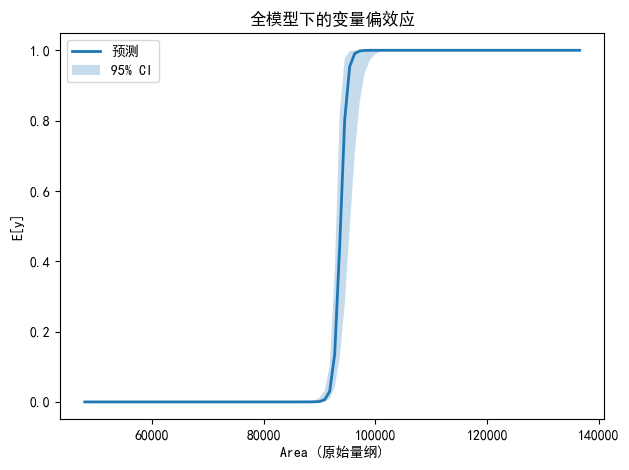

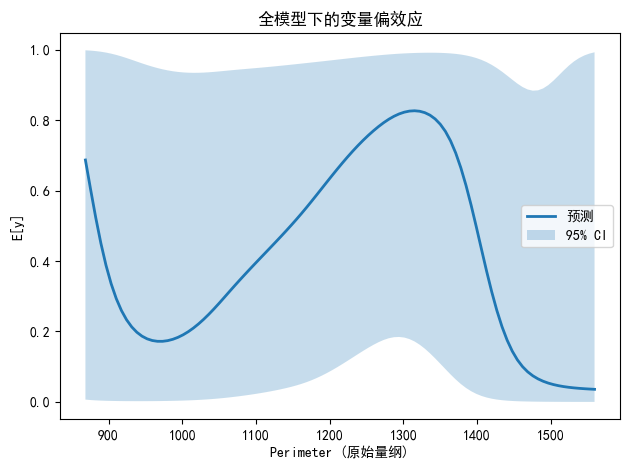

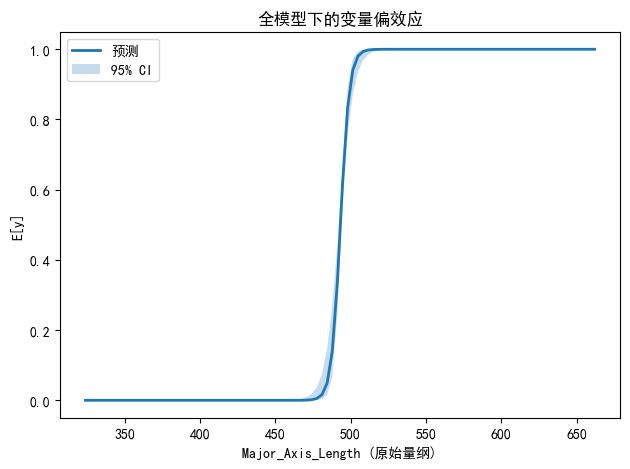

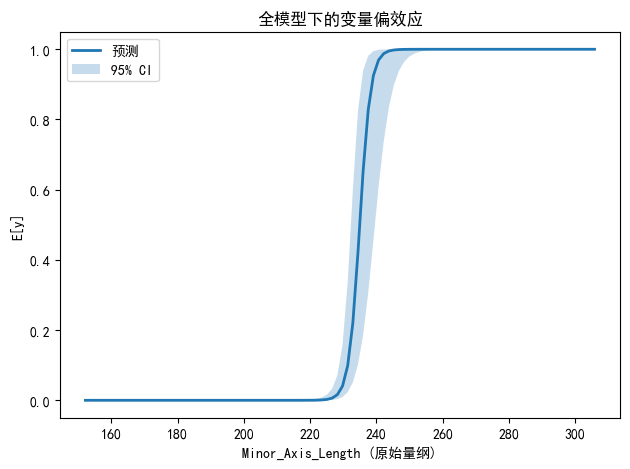

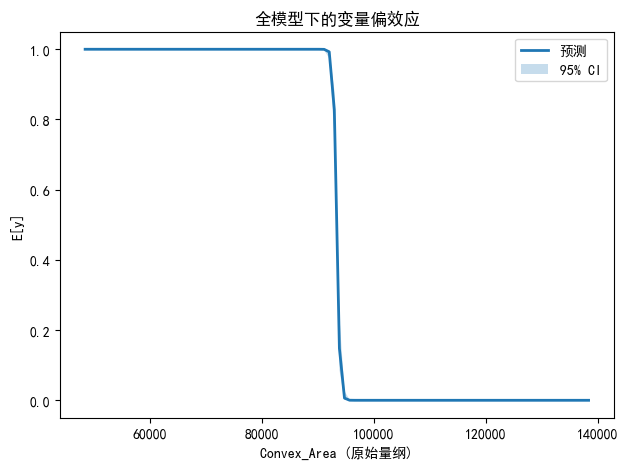

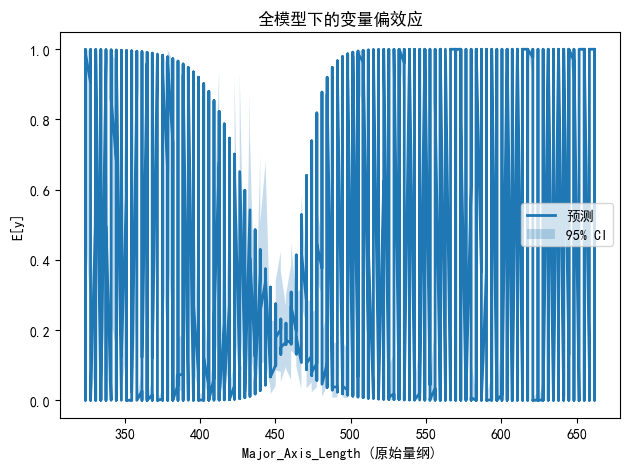

In [46]:
# ===== 依赖 =====
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

from pygam import LogisticGAM, s, te

# ===== 读数与准备 =====
df = pd.read_excel('5-Pumpkin_Seeds_Dataset.xlsx')

feature_names = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Convex_Area']
X_raw = df[feature_names].to_numpy()
y_raw = df['Class'].to_numpy()

le = LabelEncoder()
y = le.fit_transform(y_raw)

# 标准化（你原本就是先标准化再切分，这里保持一致）
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# 训练 / 测试划分（分层）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 构造 GAM：5 个一维样条 + 1 个张量样条交互 te(2,3) =====
terms = s(0, n_splines=10)
for i in range(1, 5):
    terms = terms + s(i, n_splines=10)
terms_inter = terms + te(2, 3, n_splines=10)

# 你的“最优加权 λ”（注意：te 的 λ 必须是长度为 2 的列表）
best_lam = [0.96, 0.01, 120.0, 0.18, 300.0, [1.0, 1.0]]

# ===== 10 折分层交叉验证（固定最优 λ，不做网格搜索）=====
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_aucs = []
cv_lls  = []

for tr, va in skf.split(X_train, y_train):
    model_cv = LogisticGAM(terms_inter, lam=best_lam, max_iter=1000).fit(X_train[tr], y_train[tr])
    prob_cv  = model_cv.predict_mu(X_train[va])  # 概率
    cv_aucs.append(roc_auc_score(y_train[va], prob_cv))
    cv_lls.append(log_loss(y_train[va], prob_cv, labels=[0, 1]))

print(f"CV AUC: {np.mean(cv_aucs):.4f} ± {np.std(cv_aucs):.4f} | CV logloss: {np.mean(cv_lls):.4f}")

# ===== 在全训练集上重拟合最终模型 =====
best_model_inter_weight = LogisticGAM(terms_inter, lam=best_lam, max_iter=1000).fit(X_train, y_train)

# ===== 测试集指标 =====
prob_test = best_model_inter_weight.predict_mu(X_test)
auc_test  = roc_auc_score(y_test, prob_test)
ll_test   = log_loss(y_test, prob_test, labels=[0, 1])
acc_test  = accuracy_score(y_test, (prob_test >= 0.5).astype(int))
print(f"Test AUC={auc_test:.4f} | logloss={ll_test:.4f} | Acc={acc_test:.4f}")

# ===== 工具：把标准化值还原成原始量纲 =====
def to_original(std_vals, j):
    """std_vals: 标准化尺度上的值（可为一维或二维数组），j: 第 j 个特征"""
    return std_vals * scaler.scale_[j] + scaler.mean_[j]

import os

# Ensure the directory exists
# output_dir = r"D:\课堂\大三上\定性数据分析\figure\withP"
# os.makedirs(output_dir, exist_ok=True)

# Save the figure to the specified folder

# ===== 画 PDP（单变量 + 交互），x 轴显示原始量纲 =====
for i, term in enumerate(best_model_inter_weight.terms):
    if term.isintercept:
        continue

    # ---------- 1D 单变量项 ----------
    if hasattr(term, "feature"):
        # term.feature 可能是标量或长度为1的序列
        feat_idx = term.feature
        if isinstance(feat_idx, (list, tuple, np.ndarray)):
            feat_idx = int(np.array(feat_idx).ravel()[0])
        else:
            feat_idx = int(feat_idx)

        XX = best_model_inter_weight.generate_X_grid(term=i)  # (n_points, n_features) —— 标准化尺度
        # 线性预测及其置信区间
        lp, confi = best_model_inter_weight.partial_dependence(term=i, X=XX, width=0.95)

        # 转为响应尺度（概率）
        mu    = best_model_inter_weight.link.mu(lp, best_model_inter_weight.distribution)
        mu_lo = best_model_inter_weight.link.mu(confi[:, 0], best_model_inter_weight.distribution)
        mu_hi = best_model_inter_weight.link.mu(confi[:, 1], best_model_inter_weight.distribution)

        # 取该特征的横坐标，并还原回原始量纲
        x_std  = XX[:, feat_idx]
        x_orig = to_original(x_std, feat_idx)

        order = np.argsort(x_orig)
        
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体支持中文
        plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
        plt.figure()
        plt.plot(x_orig[order], mu[order], lw=2, label="预测")
        plt.fill_between(x_orig[order], mu_lo[order], mu_hi[order], alpha=0.25, label="95% CI")
        plt.xlabel(f"{feature_names[feat_idx]} (原始量纲)")
        plt.ylabel("E[y]")
        plt.title("全模型下的变量偏效应")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ---------- 2D 张量 te(Major, Minor) ----------
    else:
        # 对 te(...)，term 通常有 feature 属性为两个下标；若没有，用已知的 (2,3)
        feat_pair = getattr(term, "feature", (2, 3))
        feat_pair = tuple(int(x) for x in np.array(feat_pair).ravel().tolist())

        XP, XQ = best_model_inter_weight.generate_X_grid(term=i, meshgrid=True)  # 标准化尺度网格

        # 线性预测及 CI
        lp, confi = best_model_inter_weight.partial_dependence(
            term=i, X=(XP, XQ), meshgrid=True, width=0.95
        )

        # 映射并 reshape 回网格
        mu    = best_model_inter_weight.link.mu(lp, best_model_inter_weight.distribution).reshape(XP.shape)
        mu_lo = best_model_inter_weight.link.mu(confi[:, 0], best_model_inter_weight.distribution).reshape(XP.shape)
        mu_hi = best_model_inter_weight.link.mu(confi[:, 1], best_model_inter_weight.distribution).reshape(XP.shape)

        # 还原两个轴的原始量纲
        XP_orig = to_original(XP, feat_pair[0])
        XQ_orig = to_original(XQ, feat_pair[1])

        plt.figure()
        cs = plt.contourf(XP_orig, XQ_orig, mu, levels=20)
        plt.colorbar(cs, label="E[y] ")
        # 可选：CI 等值线（示意）
        plt.contour(XP_orig, XQ_orig, mu_lo, levels=10, linestyles='dashed')
        plt.contour(XP_orig, XQ_orig, mu_hi, levels=10, linestyles='dashed')
        plt.xlabel(f"{feature_names[feat_pair[0]]} (原始量纲)")
        plt.ylabel(f"{feature_names[feat_pair[1]]} (原始量纲)")
        plt.title("全模型下的变量偏效应")
        plt.tight_layout()
        plt.show()


CV AUC: 0.9470 ± 0.0200 | CV logloss: 0.2891
Test AUC=0.9491 | logloss=0.2798 | Acc=0.8800


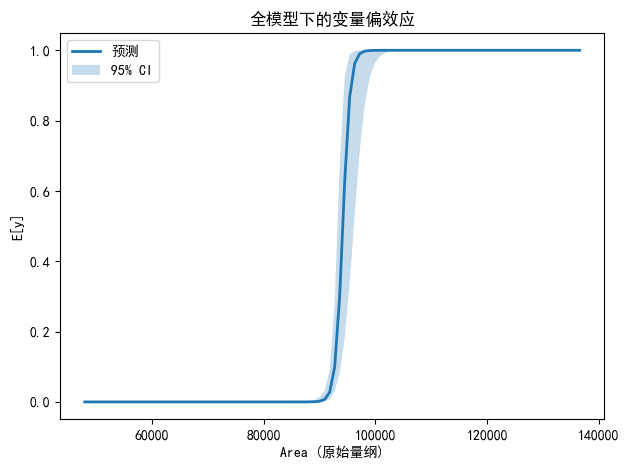

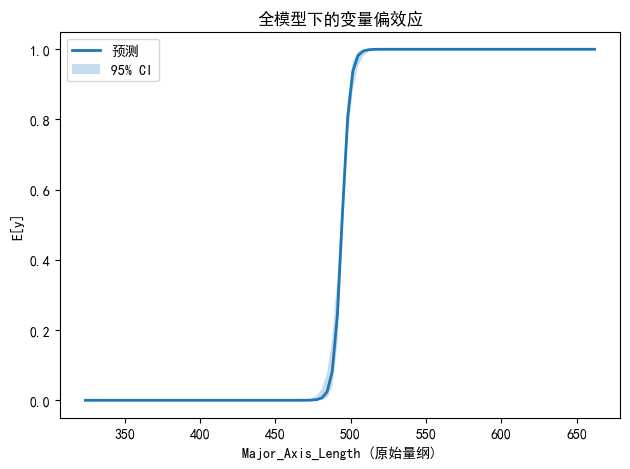

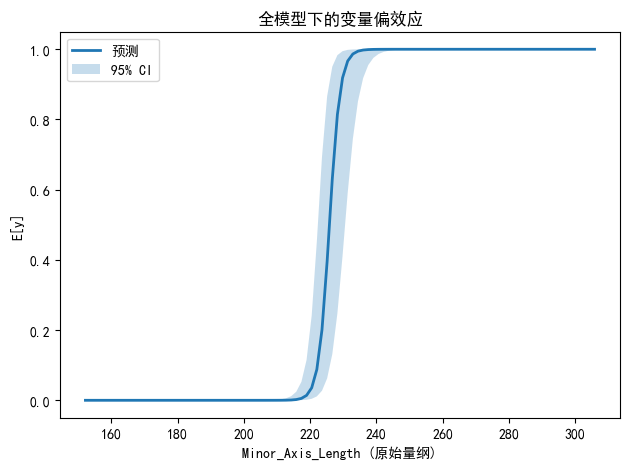

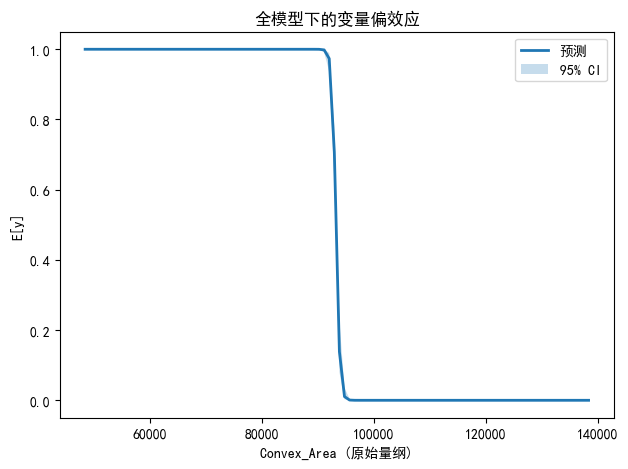

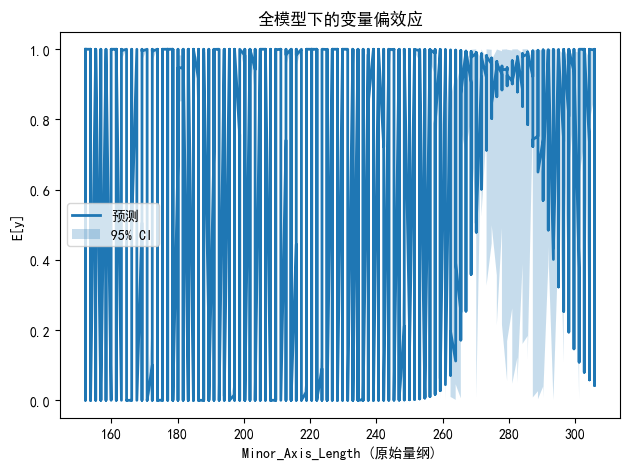

In [47]:
# ===== 依赖 =====
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

from pygam import LogisticGAM, s, te

# ===== 读数与准备 =====
df = pd.read_excel('5-Pumpkin_Seeds_Dataset.xlsx')

feature_names = ['Area', 'Major_Axis_Length', 'Minor_Axis_Length', 'Convex_Area']
X_raw = df[feature_names].to_numpy()
y_raw = df['Class'].to_numpy()

le = LabelEncoder()
y = le.fit_transform(y_raw)

# 标准化（你原本就是先标准化再切分，这里保持一致）
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# 训练 / 测试划分（分层）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 构造 GAM：5 个一维样条 + 1 个张量样条交互 te(2,3) =====
terms = s(0, n_splines=10)
for i in range(1, 4):
    terms = terms + s(i, n_splines=10)
terms_inter = terms + te(2, 3, n_splines=10)

# 你的“最优加权 λ”（注意：te 的 λ 必须是长度为 2 的列表）
best_lam = [0.96, 120.0, 0.18, 300.0, [1.0, 1.0]]

# ===== 10 折分层交叉验证（固定最优 λ，不做网格搜索）=====
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_aucs = []
cv_lls  = []

for tr, va in skf.split(X_train, y_train):
    model_cv = LogisticGAM(terms_inter, lam=best_lam, max_iter=1000).fit(X_train[tr], y_train[tr])
    prob_cv  = model_cv.predict_mu(X_train[va])  # 概率
    cv_aucs.append(roc_auc_score(y_train[va], prob_cv))
    cv_lls.append(log_loss(y_train[va], prob_cv, labels=[0, 1]))

print(f"CV AUC: {np.mean(cv_aucs):.4f} ± {np.std(cv_aucs):.4f} | CV logloss: {np.mean(cv_lls):.4f}")

# ===== 在全训练集上重拟合最终模型 =====
best_model_inter_weight = LogisticGAM(terms_inter, lam=best_lam, max_iter=1000).fit(X_train, y_train)

# ===== 测试集指标 =====
prob_test = best_model_inter_weight.predict_mu(X_test)
auc_test  = roc_auc_score(y_test, prob_test)
ll_test   = log_loss(y_test, prob_test, labels=[0, 1])
acc_test  = accuracy_score(y_test, (prob_test >= 0.5).astype(int))
print(f"Test AUC={auc_test:.4f} | logloss={ll_test:.4f} | Acc={acc_test:.4f}")

def to_original(std_vals, j):
    """std_vals: 标准化尺度上的值（可为一维或二维数组），j: 第 j 个特征"""
    return std_vals * scaler.scale_[j] + scaler.mean_[j]

import os

# Ensure the directory exists
# output_dir = r"D:\课堂\大三上\定性数据分析\figure\withP"
# os.makedirs(output_dir, exist_ok=True)

# Save the figure to the specified folder

# ===== 画 PDP（单变量 + 交互），x 轴显示原始量纲 =====
for i, term in enumerate(best_model_inter_weight.terms):
    if term.isintercept:
        continue

    # ---------- 1D 单变量项 ----------
    if hasattr(term, "feature"):
        # term.feature 可能是标量或长度为1的序列
        feat_idx = term.feature
        if isinstance(feat_idx, (list, tuple, np.ndarray)):
            feat_idx = int(np.array(feat_idx).ravel()[0])
        else:
            feat_idx = int(feat_idx)

        XX = best_model_inter_weight.generate_X_grid(term=i)  # (n_points, n_features) —— 标准化尺度
        # 线性预测及其置信区间
        lp, confi = best_model_inter_weight.partial_dependence(term=i, X=XX, width=0.95)

        # 转为响应尺度（概率）
        mu    = best_model_inter_weight.link.mu(lp, best_model_inter_weight.distribution)
        mu_lo = best_model_inter_weight.link.mu(confi[:, 0], best_model_inter_weight.distribution)
        mu_hi = best_model_inter_weight.link.mu(confi[:, 1], best_model_inter_weight.distribution)

        # 取该特征的横坐标，并还原回原始量纲
        x_std  = XX[:, feat_idx]
        x_orig = to_original(x_std, feat_idx)

        order = np.argsort(x_orig)
        
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体支持中文
        plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
        plt.figure()
        plt.plot(x_orig[order], mu[order], lw=2, label="预测")
        plt.fill_between(x_orig[order], mu_lo[order], mu_hi[order], alpha=0.25, label="95% CI")
        plt.xlabel(f"{feature_names[feat_idx]} (原始量纲)")
        plt.ylabel("E[y]")
        plt.title("全模型下的变量偏效应")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ---------- 2D 张量 te(Major, Minor) ----------
    else:
        # 对 te(...)，term 通常有 feature 属性为两个下标；若没有，用已知的 (2,3)
        feat_pair = getattr(term, "feature", (2, 3))
        feat_pair = tuple(int(x) for x in np.array(feat_pair).ravel().tolist())

        XP, XQ = best_model_inter_weight.generate_X_grid(term=i, meshgrid=True)  # 标准化尺度网格

        # 线性预测及 CI
        lp, confi = best_model_inter_weight.partial_dependence(
            term=i, X=(XP, XQ), meshgrid=True, width=0.95
        )

        # 映射并 reshape 回网格
        mu    = best_model_inter_weight.link.mu(lp, best_model_inter_weight.distribution).reshape(XP.shape)
        mu_lo = best_model_inter_weight.link.mu(confi[:, 0], best_model_inter_weight.distribution).reshape(XP.shape)
        mu_hi = best_model_inter_weight.link.mu(confi[:, 1], best_model_inter_weight.distribution).reshape(XP.shape)

        # 还原两个轴的原始量纲
        XP_orig = to_original(XP, feat_pair[0])
        XQ_orig = to_original(XQ, feat_pair[1])

        plt.figure()
        cs = plt.contourf(XP_orig, XQ_orig, mu, levels=20)
        plt.colorbar(cs, label="E[y] ")
        # 可选：CI 等值线（示意）
        plt.contour(XP_orig, XQ_orig, mu_lo, levels=10, linestyles='dashed')
        plt.contour(XP_orig, XQ_orig, mu_hi, levels=10, linestyles='dashed')
        plt.xlabel(f"{feature_names[feat_pair[0]]} (原始量纲)")
        plt.ylabel(f"{feature_names[feat_pair[1]]} (原始量纲)")
        plt.title("全模型下的变量偏效应")
        plt.tight_layout()
        plt.show()


In [29]:
# 消融（固定最优加权 λ，不做网格搜索）

# 1) 规范化 best_lam：前5个是5个 s() 的 λ；最后是 te 的两个方向 λ
if isinstance(best_lam[-1], (list, tuple)):
    lam_s = list(best_lam[:5])
    lam_te = list(best_lam[-1])
else:
    if len(best_lam) >= 7:
        lam_s = list(best_lam[:5])
        lam_te = [best_lam[5], best_lam[6]]
    else:  
        lam_s = list(best_lam[:5])
        lam_te = [best_lam[5], best_lam[5]]


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = list(skf.split(X_train, y_train))


def build_terms_and_lam(cols, add_inter=True, n_spl=10):
    """
    cols: 使用的原始列索引（0..4）：[Area, Perimeter, Major, Minor, Convex]
    add_inter: 是否保留 te(Major, Minor)
    返回：terms, lam_list（与 terms 对齐）
    """
    # 子集后的新索引映射
    idx_map = {old: i for i, old in enumerate(cols)}

    # 单变量样条项
    t = s(0, n_splines=n_spl)
    for j in range(1, len(cols)):
        t = t + s(j, n_splines=n_spl)

    # 构建对应的 lam_list
    lam_list = [lam_s[c] for c in cols]

    # te(Major, Minor) 仅当二者都在子集中且 add_inter=True
    if add_inter and (2 in cols) and (3 in cols):
        i = idx_map[2]
        j = idx_map[3]
        t = t + te(i, j, n_splines=10)
        lam_list.append(lam_te[:2])  # 两个方向的 λ
    return t, lam_list

def cv_auc_logloss_fixed_lam(Xtr, ytr, cols, add_inter=True):
    terms, lam_list = build_terms_and_lam(cols, add_inter=add_inter, n_spl=10)
    fold_aucs, fold_lls = [], []
    Xsub = Xtr[:, cols]
    for tr, va in folds:
        m = LogisticGAM(terms, max_iter=1000,lam=lam_list).fit(Xsub[tr], ytr[tr])
        prob = m.predict_mu(Xsub[va])
        fold_aucs.append(roc_auc_score(ytr[va], prob))
        fold_lls.append(log_loss(ytr[va], prob, labels=[0,1]))
    # 用全训练集重拟合一个最终模型
    final_model = LogisticGAM(terms, max_iter=1000,lam=lam_list).fit(Xsub, ytr)
    return np.array(fold_aucs), np.array(fold_lls), final_model

def test_metrics_fixed(model, cols):
    Xsub_test = X_test[:, cols]
    prob = model.predict_mu(Xsub_test)
    auc = roc_auc_score(y_test, prob)
    ll = log_loss(y_test, prob, labels=[0,1])
    acc = accuracy_score(y_test, (prob >= 0.5).astype(int))
    return auc, ll, acc

# 4) 设定要对比的消融配置（遵守层级：若丢 Major/Minor 则不能保留其交互）
experiments = {
    "BASE_含交互_5特征":          ([0,1,2,3,4], True),
    "去交互_5特征":               ([0,1,2,3,4], False),
    "去Convex_含交互":            ([0,1,2,3],   True),
    "去Perimeter_含交互":         ([0,2,3,4],   True),
    "去Perimeter+Convex_含交互":  ([0,2,3],     True),  
}

results = {}

base_key = "BASE_含交互_5特征"

for name, (cols, add_inter) in experiments.items():
    fold_aucs, fold_lls, mdl = cv_auc_logloss_fixed_lam(X_train, y_train, cols, add_inter=add_inter)
    t_auc, t_ll, t_acc = test_metrics_fixed(mdl, cols)
    results[name] = {
        "cols": cols, "add_inter": add_inter,
        "cv_auc_mean": float(fold_aucs.mean()),
        "cv_auc_std":  float(fold_aucs.std()),
        "cv_ll_mean":  float(fold_lls.mean()),
        "test_auc": t_auc, "test_logloss": t_ll, "test_acc": t_acc,
        "fold_aucs": fold_aucs, "fold_lls": fold_lls,
    }


base_auc_folds = results[base_key]["fold_aucs"]
base_ll_folds  = results[base_key]["fold_lls"]

print("\n=== 消融（固定最优加权λ，无网格搜索） ===")
for k, v in results.items():
    print(f"\n[{k}]  列: {v['cols']}  交互: {v['add_inter']}")
    print(f"  CV AUC: {v['cv_auc_mean']:.4f} ± {v['cv_auc_std']:.4f} | CV logloss: {v['cv_ll_mean']:.4f}")
    print(f"  Test: AUC={v['test_auc']:.4f} | logloss={v['test_logloss']:.4f} | Acc={v['test_acc']:.4f}")
    if k != base_key:
        d_auc = v["fold_aucs"] - base_auc_folds
        d_ll  = v["fold_lls"]  - base_ll_folds
        print(f"  相对基线 ΔAUC(配对10折) = {d_auc.mean():+.4f} (std {d_auc.std():.4f})")
        print(f"  相对基线 Δlogloss(配对10折) = {d_ll.mean():+.4f} (std {d_ll.std():.4f})")



=== 消融（固定最优加权λ，无网格搜索） ===

[BASE_含交互_5特征]  列: [0, 1, 2, 3, 4]  交互: True
  CV AUC: 0.9459 ± 0.0203 | CV logloss: 0.2920
  Test: AUC=0.9512 | logloss=0.2752 | Acc=0.8800

[去交互_5特征]  列: [0, 1, 2, 3, 4]  交互: False
  CV AUC: 0.9446 ± 0.0208 | CV logloss: 0.2941
  Test: AUC=0.9474 | logloss=0.2824 | Acc=0.8760
  相对基线 ΔAUC(配对10折) = -0.0013 (std 0.0023)
  相对基线 Δlogloss(配对10折) = +0.0021 (std 0.0060)

[去Convex_含交互]  列: [0, 1, 2, 3]  交互: True
  CV AUC: 0.9398 ± 0.0194 | CV logloss: 0.3062
  Test: AUC=0.9421 | logloss=0.3029 | Acc=0.8660
  相对基线 ΔAUC(配对10折) = -0.0061 (std 0.0046)
  相对基线 Δlogloss(配对10折) = +0.0142 (std 0.0132)

[去Perimeter_含交互]  列: [0, 2, 3, 4]  交互: True
  CV AUC: 0.9470 ± 0.0200 | CV logloss: 0.2888
  Test: AUC=0.9493 | logloss=0.2783 | Acc=0.8820
  相对基线 ΔAUC(配对10折) = +0.0010 (std 0.0012)
  相对基线 Δlogloss(配对10折) = -0.0031 (std 0.0029)

[去Perimeter+Convex_含交互]  列: [0, 2, 3]  交互: True
  CV AUC: 0.9411 ± 0.0188 | CV logloss: 0.3043
  Test: AUC=0.9383 | logloss=0.3097 | Acc=0.8660
  相对基